In [28]:
import streamlit as st
import pandas as pd
import numpy as np
import random
import os  # Untuk menangani jalur file gambar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [29]:
# Load dataset
data = pd.read_csv("dataset.csv")

In [30]:
# Tambahkan kolom rating jika belum ada, lalu simpan agar permanen
if 'rating' not in data.columns:
    data['rating'] = np.random.randint(1, 6, size=len(data))
    data.to_csv("dataset.csv", index=False)  # Simpan ke file agar tetap konsisten

In [31]:
# Pastikan membaca dataset terbaru setelah pembaruan rating
data = pd.read_csv("dataset.csv")


In [32]:
data.isnull().sum()


id             0
name           0
ingredients    6
steps          0
image          0
rating         0
dtype: int64

In [33]:
data.dropna(inplace=True)


In [34]:
data.isnull().sum()

id             0
name           0
ingredients    0
steps          0
image          0
rating         0
dtype: int64

In [35]:
data.duplicated().sum()


np.int64(0)

In [36]:
data.drop_duplicates(inplace=True)


In [37]:
data['rating'] = pd.to_numeric(data['rating'], errors='coerce')


In [38]:
data = data[(data['rating'] >= 1) & (data['rating'] <= 5)]


In [39]:
# Rename columns
data.rename(columns={'Unnamed: 0': 'id', 'Title': 'name', 'Ingredients': 'ingredients',
                     'Instructions': 'steps', 'Image_Name': 'image'}, inplace=True)

In [40]:
# Pilih kolom yang relevan
new_data = data[['id', 'name', 'ingredients', 'steps', 'image', 'rating']]


In [41]:
# Tetapkan cluster berdasarkan nilai rating dengan kategori baru
new_data['cluster'] = np.where(new_data['rating'] == 1, 1, 
                        np.where(new_data['rating'] == 2, 2, 
                        np.where(new_data['rating'] == 3, 3, 
                        np.where(new_data['rating'] == 4, 4, 5)))) 

# Tetapkan label cluster sesuai rating yang diperbarui
new_data['cluster_label'] = new_data['cluster'].map({
    1: 'Boleh Dicoba',
    2: 'Enak',
    3: 'Lezat',
    4: 'Populer',
    5: 'Favorite!!!'
})


In [42]:
import re  

new_data['ingredients'] = new_data['ingredients'].apply(lambda x: x.lower() if isinstance(x, str) else x)  
print("Sebelum preprocessing:", new_data['ingredients'].head(5))
import re  

# Bersihkan teks dari karakter yang tidak relevan, tapi pertahankan angka
# Mempertahankan angka, pecahan (½), tanda koma, titik, dan tanda hubung
new_data['ingredients'] = new_data['ingredients'].apply(
    lambda x: re.sub(r'[^a-zA-Z0-9¼½¾\s,./()-]', '', x) if isinstance(x, str) else x
)
print("Sesudah preprocessing:", new_data['ingredients'].head(5))



Sebelum preprocessing: 0    1 (3½–4-lb.) whole chicken, 2¾ tsp. kosher sal...
1    2 large egg whites, 1 pound new potatoes (abou...
2    1 cup evaporated milk, 1 cup whole milk, 1 tsp...
3    1 (¾- to 1-pound) round italian loaf, cut into...
4    1 teaspoon dark brown sugar, 1 teaspoon hot wa...
Name: ingredients, dtype: object
Sesudah preprocessing: 0    1 (3½4-lb.) whole chicken, 2¾ tsp. kosher salt...
1    2 large egg whites, 1 pound new potatoes (abou...
2    1 cup evaporated milk, 1 cup whole milk, 1 tsp...
3    1 (¾- to 1-pound) round italian loaf, cut into...
4    1 teaspoon dark brown sugar, 1 teaspoon hot wa...
Name: ingredients, dtype: object


In [43]:
import ast  

new_data['ingredients'] = new_data['ingredients'].apply(lambda x: ', '.join(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else x)


In [44]:
max_features_values = [5000, 10000, 20000]
for max_feat in max_features_values:
    cv_test = TfidfVectorizer(max_features=max_feat, stop_words='english', ngram_range=(1, 3))
    X_test = cv_test.fit_transform(new_data['ingredients'].values.astype('U'))
    print(f"Jumlah kata unik untuk max_features={max_feat}: {X_test.shape[1]}")


Jumlah kata unik untuk max_features=5000: 5000
Jumlah kata unik untuk max_features=10000: 10000
Jumlah kata unik untuk max_features=20000: 20000


In [45]:
cv_opt = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))  # Fokus kata tunggal & bigram
X_opt = cv_opt.fit_transform(new_data['ingredients'].values.astype('U'))
print("Jumlah fitur setelah optimasi:", X_opt.shape)


Jumlah fitur setelah optimasi: (13488, 10000)


In [46]:
# Gunakan K-Means dengan cluster lebih optimal
optimal_clusters = 10
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
new_data['category_num'] = kmeans.fit_predict(X_opt)

In [48]:
# Pemetaan kategori lebih rinci berdasarkan ingredients
def categorize_food(ingredients):
    ingredients = ingredients.lower()

    # 🍖 Daging & Protein Hewani
    if any(item in ingredients for item in ['beef', 'lamb', 'pork', 'chicken', 'turkey', 'duck', 'bacon', 'sausage']):
        return "Meat-Based"
    elif any(item in ingredients for item in ['fish', 'shrimp', 'salmon', 'tuna', 'crab', 'mussels']):
        return "Seafood"
    
    # 🥦 Sayuran & Tanaman
    elif any(item in ingredients for item in ['spinach', 'kale', 'lettuce', 'broccoli', 'carrot', 'potato', 'tomato', 'cucumber', 'mushroom']):
        return "Vegetarian"

    # 🍚 Sumber Karbohidrat
    elif any(item in ingredients for item in ['rice', 'oats', 'quinoa', 'barley', 'flour', 'bread', 'pasta', 'tortilla', 'sweet potato']):
        return "Bakery"

    # 🍶 Produk Susu & Alternatifnya
    elif any(item in ingredients for item in ['milk', 'cheese', 'butter', 'yogurt', 'almond milk', 'soy milk']):
        return "Dairy-Based"

    # 🍯 Pemanis & Perasa
    elif any(item in ingredients for item in ['sugar', 'honey', 'maple syrup', 'stevia', 'salt', 'pepper', 'garlic', 'cinnamon', 'basil', 'oregano']):
        return "Seasoning & Sweetener"

    # 🍩 Dessert & Bahan Kue
    elif any(item in ingredients for item in ['chocolate', 'cocoa', 'vanilla', 'eggs', 'baking powder']):
        return "Dessert"
    
    else:
        return "Other"

In [49]:
new_data['category'] = new_data['ingredients'].apply(categorize_food)

In [50]:
# Gunakan Naïve Bayes untuk rekomendasi
cv = TfidfVectorizer(max_features=20000, stop_words='english', ngram_range=(1, 3))
X_name = cv.fit_transform(new_data['name'].values.astype('U'))

model_recommendation = MultinomialNB(alpha=0.5)
y = np.arange(len(new_data))
model_recommendation.fit(X_name, y)

MultinomialNB(alpha=0.5)

In [51]:
from imblearn.over_sampling import SMOTE  

# Pastikan X_name (TF-IDF hasil) dan y (kategori) sudah tersedia  
smote = SMOTE(random_state=42)  
X_balanced, y_balanced = smote.fit_resample(X_name, y)  

# Konversi kembali hasil balancing ke dalam dataframe agar tetap sinkron dengan skrip utama  
balanced_data = new_data.iloc[y_balanced]  


In [52]:
model_recommendation = MultinomialNB(alpha=0.5)  
model_recommendation.fit(X_balanced, y_balanced)  


MultinomialNB(alpha=0.5)

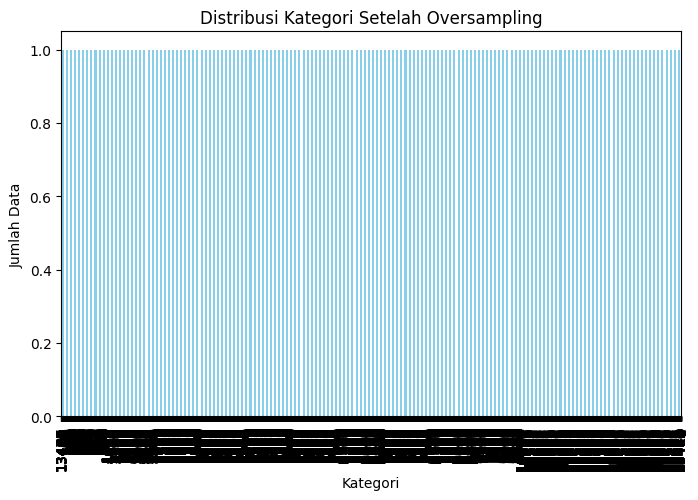

In [53]:
import matplotlib.pyplot as plt  

# Visualisasi distribusi kategori setelah oversampling  
plt.figure(figsize=(8,5))
pd.Series(y_balanced).value_counts().plot(kind='bar', color='skyblue')
plt.xlabel("Kategori")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Kategori Setelah Oversampling")
plt.show()


In [54]:
print("Jumlah data sebelum SMOTE:")
print(new_data['category'].value_counts())

print("\nJumlah data setelah SMOTE:")
print(pd.Series(y_balanced).value_counts())


Jumlah data sebelum SMOTE:
category
Meat-Based               3382
Bakery                   2815
Vegetarian               2398
Seasoning & Sweetener    1920
Dairy-Based              1591
Seafood                   843
Other                     470
Dessert                    69
Name: count, dtype: int64

Jumlah data setelah SMOTE:
13471    1
13470    1
13469    1
13468    1
13467    1
        ..
4        1
3        1
2        1
1        1
0        1
Name: count, Length: 13488, dtype: int64


In [22]:
# **Streamlit UI**
st.title("🔍 Sistem Rekomendasi Makanan")

2025-06-07 20:01:04.902 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-07 20:01:06.146 
  command:

    streamlit run C:\Python310\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-07 20:01:06.148 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [23]:
# Tentukan folder gambar
image_folder = "Food Images"

In [24]:
# Pilihan pencarian
search_option = st.radio("Pilih metode pencarian:", ["Cari berdasarkan nama", "Cari berdasarkan kategori", "Cari berdasarkan cluster"])

2025-06-07 20:01:14.347 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-07 20:01:14.349 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-07 20:01:14.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-07 20:01:14.353 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-07 20:01:14.355 Session state does not function when running a script without `streamlit run`
2025-06-07 20:01:14.358 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-07 20:01:14.361 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [25]:
# Fungsi untuk memberi warna berdasarkan rating
def color_rating(val):
    color = "#FFCCCB" if int(val) <= 3 else "#C6E5B3"
    return f"background-color: {color};"

In [26]:
# Fungsi untuk mendapatkan jalur gambar dengan pengecekan format
def get_image_path(image_name):
    for ext in [".jpg", ".png", ".jpeg"]:  # Coba beberapa kemungkinan format
        image_path = os.path.join(image_folder, image_name + ext)
        if os.path.exists(image_path):
            return image_path
    return None

In [27]:
if search_option == "Cari berdasarkan nama":
    food_name = st.text_input("Masukkan nama makanan:")
    if food_name:
        query_vec = cv.transform([food_name.lower()])
        predicted_probs = model_recommendation.predict_proba(query_vec)[0]
        top_5_indices = np.argsort(predicted_probs)[-5:][::-1]
        recommended_items = new_data.iloc[top_5_indices].dropna().reset_index(drop=True)

        st.subheader(f"🍽️ Rekomendasi untuk: {food_name}")

        for _, row in recommended_items.iterrows():
            image_path = get_image_path(row['image'].split('.')[0])  # Hapus ekstensi jika ada
            if image_path:
                html_code1 = f"""
                    <h1><span style='text-weight: bold;'>{row['name']}</span></h1>
                """
                st.markdown(html_code1, unsafe_allow_html=True)
                st.image(image_path, caption=row['name'])

                ingredients_list = row['ingredients'].split(',')
                html_code_ingredients = "<ul>"
                for ingredient in ingredients_list:
                    if ingredient.strip():  # Menghindari elemen kosong
                        html_code_ingredients += f"<li>{ingredient.strip()}</li>"
                html_code_ingredients += "</ul>"

                steps_list = row['steps'].split('.')
                html_code_steps = "<ul>"
                for step in steps_list:
                    if step.strip():  # Menghindari elemen kosong
                        html_code_steps += f"<li>{step.strip()}</li>"
                html_code_steps += "</ul>"

                html_code = f"""
                    <table border="1">
                        <tr>
                            <td>Category:</td>
                            <td>{row['category']}</td>
                        </tr>                        
                        <tr>
                            <td>Ingredients:</td>
                            <td>{html_code_ingredients}</td>
                        </tr>
                        <tr>
                            <td>Steps:</td>
                            <td>{html_code_steps}</td>
                        </tr>
                        <tr>
                            <td>Rating:</td>
                            <td>{row['rating']}</td>
                        </tr>
                        <tr>
                            <td>Cluster:</td>
                            <td>{row['cluster_label']}</td>
                        </tr>
                    </table>
                """
                st.markdown(html_code, unsafe_allow_html=True)
                st.divider()
                st.divider()
            else:
                st.write(f"⚠️ Gambar tidak ditemukan: {row['image']}")

        # st.dataframe(recommended_items.style.applymap(color_rating, subset=['rating']), width=900)
elif search_option == "Cari berdasarkan kategori":
    category_name = st.selectbox("Pilih kategori:", new_data['category'].unique())
    if category_name:
        matching_items = new_data[new_data['category'] == category_name].sample(5).dropna().reset_index(drop=True)

        st.subheader(f"Makanan dalam kategori '{category_name}':")

        for _, row in matching_items.iterrows():
            image_path = get_image_path(row['image'].split('.')[0])
            if image_path:
                html_code1 = f"""
                    <h1><span style='text-weight: bold;'>{row['name']}</span></h1>
                """
                st.markdown(html_code1, unsafe_allow_html=True)
                st.image(image_path, caption=row['name'])

                ingredients_list = row['ingredients'].split(',')
                html_code_ingredients = "<ul>"
                for ingredient in ingredients_list:
                    if ingredient.strip():  # Menghindari elemen kosong
                        html_code_ingredients += f"<li>{ingredient.strip()}</li>"
                html_code_ingredients += "</ul>"

                steps_list = row['steps'].split('.')
                html_code_steps = "<ul>"
                for step in steps_list:
                    if step.strip():  # Menghindari elemen kosong
                        html_code_steps += f"<li>{step.strip()}</li>"
                html_code_steps += "</ul>"

                html_code = f"""
                    <table border="1">
                        <tr>
                            <td>Category:</td>
                            <td>{row['category']}</td>
                        </tr>                        
                        <tr>
                            <td>Ingredients:</td>
                            <td>{html_code_ingredients}</td>
                        </tr>
                        <tr>
                            <td>Steps:</td>
                            <td>{html_code_steps}</td>
                        </tr>
                        <tr>
                            <td>Rating:</td>
                            <td>{row['rating']}</td>
                        </tr>
                        <tr>
                            <td>Cluster:</td>
                            <td>{row['cluster_label']}</td>
                        </tr>
                    </table>
                """
                st.markdown(html_code, unsafe_allow_html=True)
                st.divider()
                st.divider()
            else:
                st.write(f"⚠️ Gambar tidak ditemukan: {row['image']}")

        # st.dataframe(matching_items.style.applymap(color_rating, subset=['rating']), width=900)
elif search_option == "Cari berdasarkan cluster":
    cluster_label = st.selectbox("Pilih cluster:", new_data['cluster_label'].unique())
    if cluster_label:
        matching_items = new_data[new_data['cluster_label'] == cluster_label].sample(5).dropna().reset_index(drop=True)

        st.subheader(f"Makanan dalam cluster '{cluster_label}':")

        for _, row in matching_items.iterrows():
            image_path = get_image_path(row['image'].split('.')[0])
            if image_path:
                html_code1 = f"""
                    <h1><span style='text-weight: bold;'>{row['name']}</span></h1>
                """
                st.markdown(html_code1, unsafe_allow_html=True)
                st.image(image_path, caption=row['name'])

                ingredients_list = row['ingredients'].split(',')
                html_code_ingredients = "<ul>"
                for ingredient in ingredients_list:
                    if ingredient.strip():  # Menghindari elemen kosong
                        html_code_ingredients += f"<li>{ingredient.strip()}</li>"
                html_code_ingredients += "</ul>"

                steps_list = row['steps'].split('.')
                html_code_steps = "<ul>"
                for step in steps_list:
                    if step.strip():  # Menghindari elemen kosong
                        html_code_steps += f"<li>{step.strip()}</li>"
                html_code_steps += "</ul>"

                html_code = f"""
                    <table border="1">
                        <tr>
                            <td>Category:</td>
                            <td>{row['category']}</td>
                        </tr>                        
                        <tr>
                            <td>Ingredients:</td>
                            <td>{html_code_ingredients}</td>
                        </tr>
                        <tr>
                            <td>Steps:</td>
                            <td>{html_code_steps}</td>
                        </tr>
                        <tr>
                            <td>Rating:</td>
                            <td>{row['rating']}</td>
                        </tr>
                        <tr>
                            <td>Cluster:</td>
                            <td>{row['cluster_label']}</td>
                        </tr>
                    </table>
                """
                st.markdown(html_code, unsafe_allow_html=True)
                st.divider()
                st.divider()
            else:
                st.write(f"⚠️ Gambar tidak ditemukan: {row['image']}")

        # st.dataframe(matching_items.style.applymap(color_rating, subset=['rating']), width=900)



2025-06-07 20:01:20.484 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-07 20:01:20.486 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-07 20:01:20.489 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-07 20:01:20.491 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-07 20:01:20.493 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-07 20:01:20.496 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
